In [856]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sympy as sp

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [8,6]


The Hamiltonian is given by equation (22) from "A Qunatum Engineer's Guide to Superconducting Qubits" and is 
$$H=4E_Cn^2-E_J\sqrt{\cos(\varphi_e)^2+d^2\sin(\varphi_e)}\cos(\varphi)$$

In [857]:
nCutoff = 10
nList = np.array((range(-nCutoff, nCutoff+1)))

delta = 1


#def normalize(wavefunction):
#    normalized_wavefunction = 1/np.sqrt(delta * (wavefunction.T)@(np.conj(wavefunction))) * wavefunction
#    #normalized_wavefunction = 1/np.sqrt((wavefunction.T)@(np.conj(wavefunction))) * wavefunction
#    return normalized_wavefunction


def Hamiltonian(E_C, E_J, phi_e, d=0, n_cut = nCutoff):
    nList = np.array((range(-n_cut, n_cut+1)))

    nMatrix = np.diag(nList)
    n2Matrix = np.matmul(nMatrix, nMatrix)

    offDiag = np.ones(2*n_cut)
    cosMatrix = 0.5 *(np.diag(offDiag, k = 1) + np.diag(offDiag, k = -1))

    E_kin = 4*E_C*n2Matrix
    E_pot = -E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)*cosMatrix
    return E_kin + E_pot, E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2), nList



In [858]:
H, scale, x = Hamiltonian(1, 50, 0)

eigenvalues, eigenvectors = sc.sparse.linalg.eigsh(H, k=10, which="SA")

Text(0, 0.5, 'Energy [$GHz\\cdot h$]')

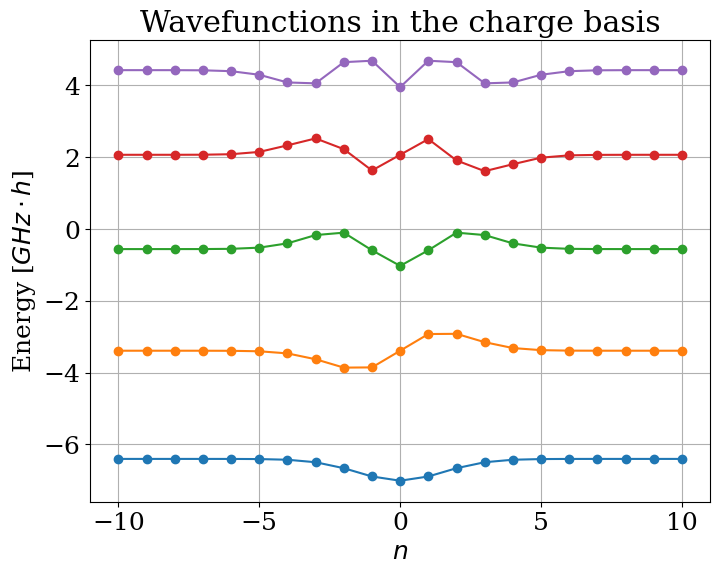

In [859]:
for i in range(5):
    plt.plot(x, -eigenvectors[:,i] + eigenvalues[i]/(2*np.pi), 'o-')

plt.title("Wavefunctions in the charge basis")
plt.xlabel("$n$")
plt.ylabel("Energy [$GHz\cdot h$]")


## Convergence check

In [860]:
def convegence(n_cut):
    nList = np.array((range(-n_cut, n_cut+1)))

    nMatrix = np.diag(nList)
    n2Matrix = np.matmul(nMatrix, nMatrix)

    offDiag = np.ones(2*n_cut)
    cosMatrix = 0.5 *(np.diag(offDiag, k = 1) + np.diag(offDiag, k = -1))

    H, scale, x = Hamiltonian(1, 50, 0, n_cut = n_cut)

    eigenvalues, eigenvectors = sc.sparse.linalg.eigsh(H, k=5, which="SA")

    return eigenvalues[:3]/(2*np.pi)


In [861]:
converg_arr = np.zeros((12, 3))

for i in range(12):
    eig = convegence(i+1)
    converg_arr[i] = eig


c:\Users\marku\anaconda3\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


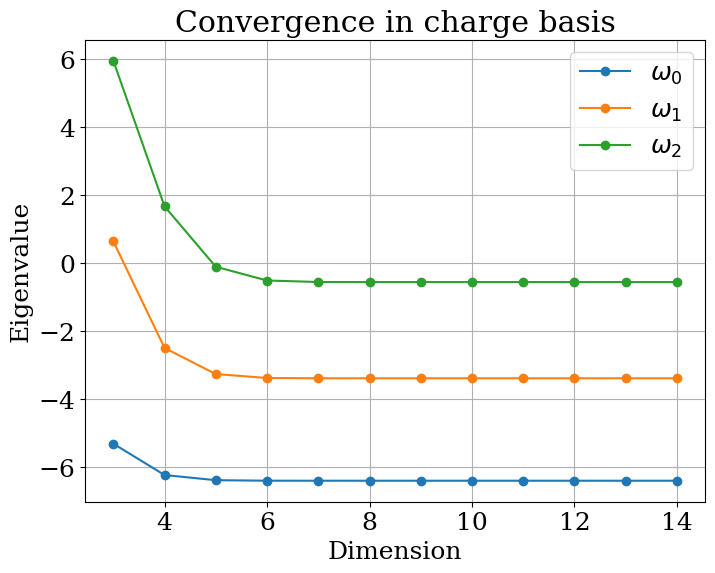

In [862]:
labels = np.array([r"$\omega_0$", r"$\omega_1$", r"$\omega_2$"])

for i in range(3):
    plt.plot(range(3,15), converg_arr[:,i], 'o-', label =labels[i])

plt.xlabel("Dimension")
plt.ylabel("Eigenvalue")
plt.title("Convergence in charge basis")
plt.legend()

From this plot is clear to see that $n_{cutoff}=10$ is approriate for the current parameters since the five lowest eigenvalues (which are the ones of interest) converge far earlier than the cut off value.

# E3)

In [863]:
eigenvalues = eigenvalues.real

nMatrix = nMatrix = np.diag(2*nList)

In [864]:
H_Q = np.zeros((3,3))

omega, H_Q[1,1] = eigenvalues[1]-eigenvalues[0], eigenvalues[1]-eigenvalues[0]
H_Q[2,2] = eigenvalues[2]-eigenvalues[0]

alpha = eigenvalues[2] - 2*eigenvalues[1] + eigenvalues[0]


nMatrix_subspace = np.diag([0, 1, 2])

In [865]:
H_C = np.zeros_like(H_Q)

nMatrix = np.diag(nList)

for i in range(3):
    for j in range(3):
        H_C[i,j] = (eigenvectors[:,j].T)@nMatrix@eigenvectors[:,i]


g1, g2 = H_C[0,1], H_C[1,2]

In [866]:
H_C.round(5)

array([[-0.     , -1.0878 ,  0.     ],
       [-1.0878 ,  0.     ,  1.49027],
       [ 0.     ,  1.49027, -0.     ]])

### b)

In [867]:
from scipy.stats import norm

def envolope(t, mean, sigma):
    return norm.pdf(t, mean, sigma)


### c)

In [868]:
T = 20

pulse_mean, pulse_sigma = T/2, 2

#The normalization constant for a normalized pulse 
A=np.pi/(g1) 


def H_t(t):
    return H_Q + A * envolope(t, pulse_mean, pulse_sigma) * np.cos(omega*t) * H_C

### d)

In [869]:
from scipy.integrate import solve_ivp

initial = np.array([1, 0, 0], dtype = np.complex64)


time = (0, T)



def diff_equation(t, y):
    return - 1j * H_t(t)@y #The -i comes from moving it form d/dt on the other side of the Schrödinger equation


results = solve_ivp(diff_equation, t_span=time, y0=initial)

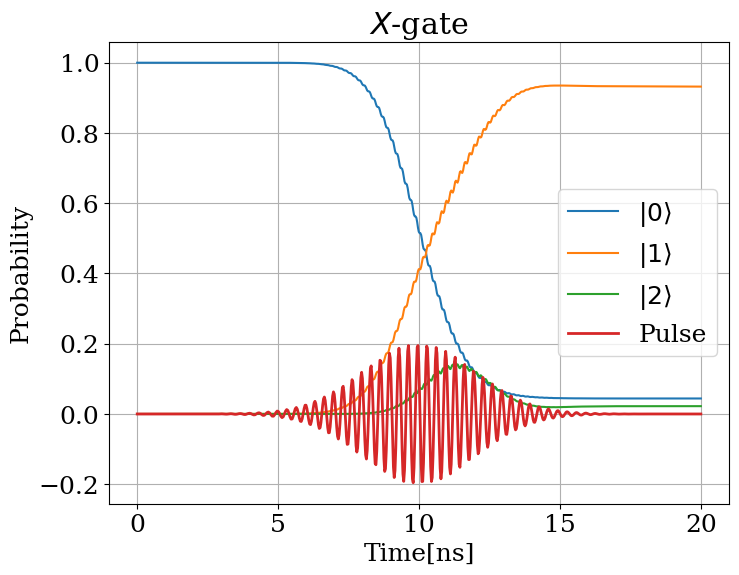

In [870]:
time_steps = results.t

solution = results.y

plt.plot(time_steps, abs(solution[0])**2, label=r"$|0\rangle$")
plt.plot(time_steps, abs(solution[1])**2, label=r"$|1\rangle$")
plt.plot(time_steps, abs(solution[2])**2, label=r"$|2\rangle$")

plt.plot(time_steps, envolope(time_steps, pulse_mean, pulse_sigma)*np.cos(omega*time_steps), linewidth=2, label = "Pulse")

plt.title("$X$-gate")
plt.xlabel("Time[ns]")
plt.ylabel("Probability")
plt.legend()

Text(0.7, 0.85, 'The final fidelity is \n0.932')

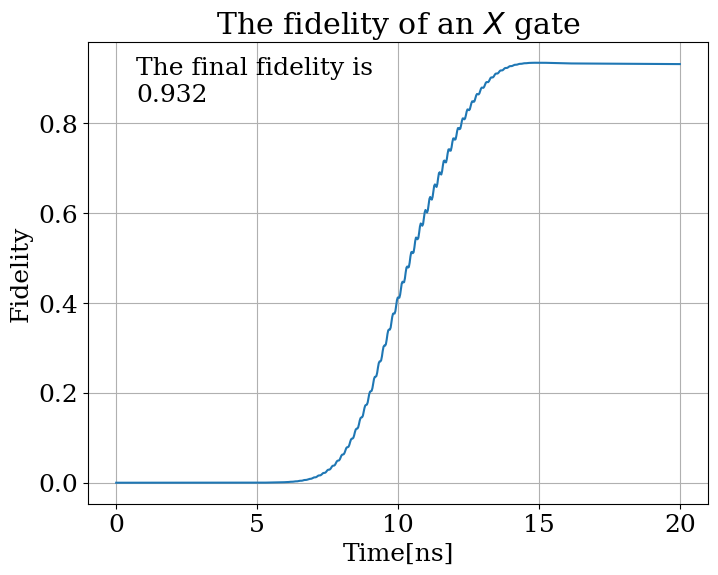

In [871]:
fidelity = np.zeros_like(time_steps)

for i in range(len(time_steps)):
    fidelity[i] = np.abs(np.array([0,1,0])@solution[:,i].T)**2

plt.plot(time_steps, fidelity)
plt.xlabel("Time[ns]")
plt.ylabel("Fidelity")
plt.title("The fidelity of an $X$ gate")

text = "The final fidelity is \n"+ str(round(np.abs(np.array([0,1,0])@solution[:,-1].T)**2, 3))

plt.text(0.7, 0.85, text)

[Text(0.5, 0, 'X-component'), Text(0, 0.5, 'Z-component')]

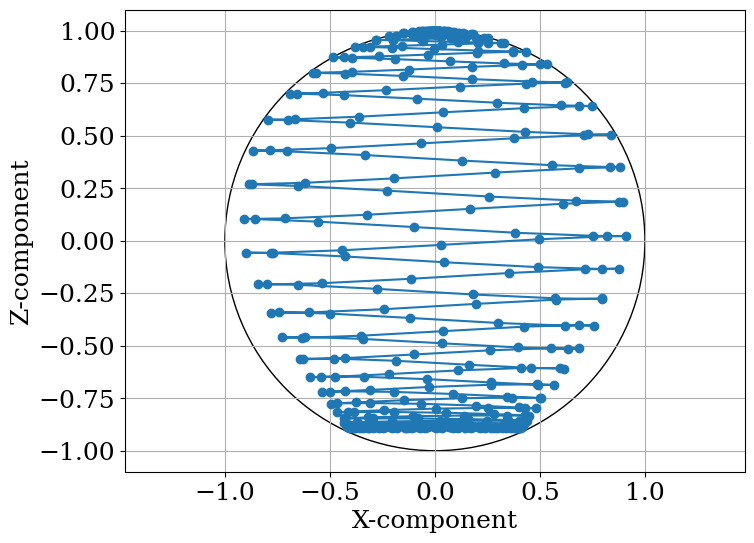

In [872]:
z_component = np.zeros_like(time_steps)
y_component = np.zeros_like(time_steps)
x_component = np.zeros_like(time_steps)

for i in range(len(time_steps)):
    z_component[i] = np.abs(np.array([1,0,0])@solution[:,i].T)**2 - np.abs(np.array([0,1,0])@solution[:,i].T)**2
    y_component[i] = np.abs(np.array([1,1j,0])@solution[:,i].T /np.sqrt(2))**2 - np.abs(np.array([1,-1j,0])@solution[:,i].T /np.sqrt(2))**2
    x_component[i] = np.abs(np.array([1,1,0])@solution[:,i].T /np.sqrt(2))**2 - np.abs(np.array([1,-1,0])@solution[:,i].T /np.sqrt(2))**2


fig, ax = plt.subplots()
ax.plot(x_component, z_component, "-o")
circle = plt.Circle((0,0), 1, fill=False)
ax.add_patch(circle)
ax.axis("equal")
ax.set(xlabel="X-component", ylabel="Z-component")

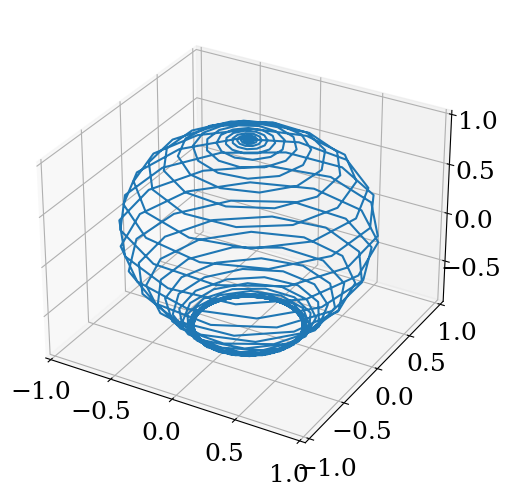

In [873]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(x_component, y_component, z_component, "-")

In [874]:
round(np.abs(np.array([0,1,0])@solution[:,-1].T)**2, 5)*100

93.201

### e) An attempt at implementing DRAG

In [875]:
def derivative(t, mean, sigma):
    return (t-mean)/sigma**2 * norm.pdf(t, mean, sigma)

def drive(t, lamb):
    normalize_constant = 1/(envolope(t, pulse_mean, pulse_sigma) + lamb*derivative(t, pulse_mean, pulse_sigma)/alpha)
    I = normalize_constant *  envolope(t, pulse_mean, pulse_sigma) * np.cos(omega*t) 
    Q = normalize_constant *  lamb*derivative(t, pulse_mean, pulse_sigma)/alpha * np.sin(omega*t)
    return Q + I

def DRAG_H(t, lambd):
    return H_Q + A * drive(t, lambd) * H_C

lambd_arr = np.linspace(0, 1, 10) #Different values of lambda

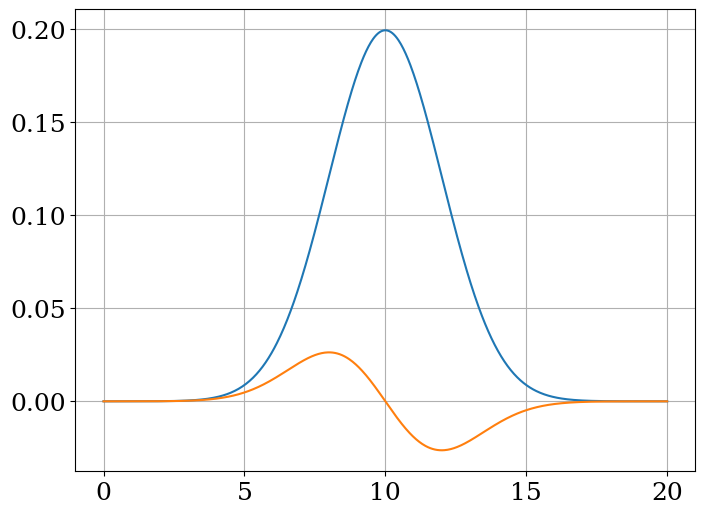

In [876]:
plt.plot(time_steps, envolope(time_steps, pulse_mean, pulse_sigma))
plt.plot(time_steps, 0.5 * derivative(time_steps, pulse_mean, pulse_sigma)/alpha)

C:\Users\marku\AppData\Local\Temp\ipykernel_11404\1562438761.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  normalize_constant = 1/(envolope(t, pulse_mean, pulse_sigma) + lamb*derivative(t, pulse_mean, pulse_sigma)/alpha)
C:\Users\marku\AppData\Local\Temp\ipykernel_11404\1562438761.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return Q + I
c:\Users\marku\anaconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


Text(0, 0.5, 'Fidelity')

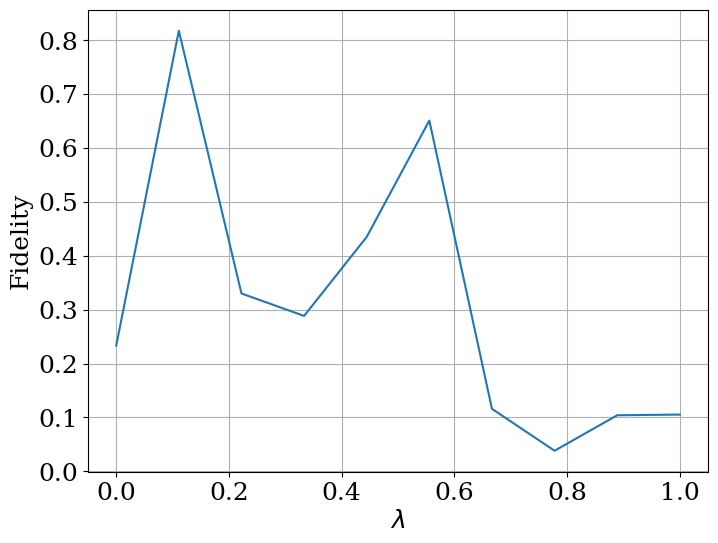

In [877]:
fidel = np.zeros_like(lambd_arr)

for i in range(len(lambd_arr)):
    def H_t(t):
        return DRAG_H(t, i)

    def diff_equation_DRAG(t, y):
        return - 1j * H_t(t)@y #The -i comes from moving it form d/dt on the other side of the Schrödinger equation


    results = solve_ivp(diff_equation, t_span=time, y0=initial, first_step = dt/100)

    fidel[i] = np.abs(np.array([0,1,0])@results.y[:,-1])**2
    

plt.plot(lambd_arr, fidel)
plt.xlabel(r"$\lambda$")
plt.ylabel("Fidelity")

In [878]:
max_fidelity = lambd_arr[np.argmax(fidel)]

Text(0, 0.5, 'Fidelity of gate')

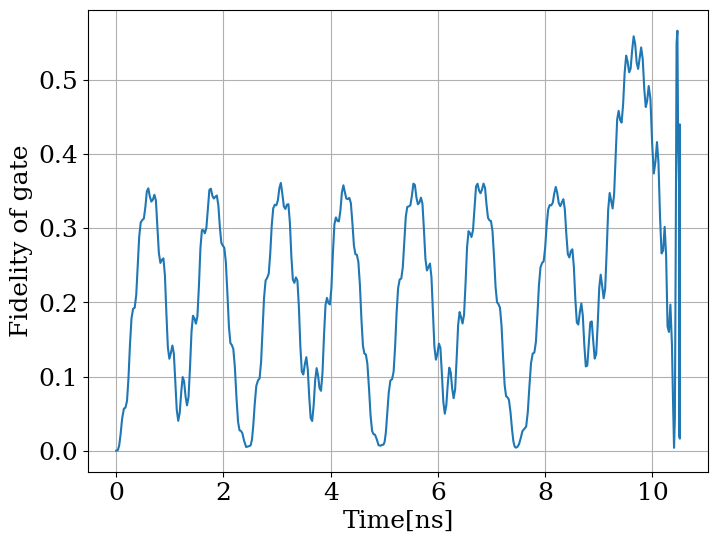

In [879]:
def diff_equation_DRAG(t, y):
        return - 1j * DRAG_H(t, 1)@y #The -i comes from moving it form d/dt on the other side of the Schrödinger equation


results_DRAG = solve_ivp(diff_equation, t_span=time, y0=initial)

fidel_DRAG = np.zeros_like(results_DRAG.t)

for i in range(len(results_DRAG.t)):
        fidel_DRAG[i] = np.abs(np.array([0,1,0])@results_DRAG.y[:,i])**2

plt.plot(results_DRAG.t, fidel_DRAG)
plt.xlabel("Time[ns]")
plt.ylabel("Fidelity of gate")